In [1]:
import numpy as np
import psycopg2 as psy
import pandas as pd
import scipy as sp
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from IPython.display import display

%matplotlib inline
pd.options.display.precision = 4

## 1. Verify Database Connection By Displaying First 5 Rows with Column Heads

In [2]:
from lib.database_helper import connect_and_cursor, execute_query, sql_to_df

You have three helper functions you can use to do this:

- `connect_and_cursor`
  - takes three arguments: 
     - `this_host`
     - `this_user`
     - `this_password`
  - returns two objects
     - a `connection` to the database
     - a read/write `cursor` to the database
  - e.g. 
  
    ```
    connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
    ```
- `execute_query`
  - takes three arguments
    - a database `connection`
    - a database `cursor`
    - a SQL `query`
  - if the query is successful
     - returns `None`
     - the results are available via the cursor
  - e.g. 
 
    ```
    execute_query(connection, cursor, "SELECT * FROM titanic LIMIT 5;"
    query_results = cursor.fetchall()
    ```
  - if the query is unsuccessful returns an error message   
- `sql_to_df`
  - has one required argument (a `cursor.fetchall()`) and a second optional argument (a `list` of column headers)
  - returns the results of the query as a DataFrame 
  - e.g.
  
    ```
    sql_to_df(query_results)
    ```

### Use the helper functions to display the first 5 rows of the table

You should use the following pattern to connect:

    connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
    execute_query(connection, cursor, "SELECT * FROM titanic LIMIT 5;"
    query_results = cursor.fetchall()
    sql_to_df(query_results)
    connection.close()
    ```
    
Note that we have made sure to `close` the connection. This is considered a best practice.    

In [3]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, "SELECT * FROM titanic LIMIT 5;")
query_results = cursor.fetchall()
display(sql_to_df(query_results, columns=['some col', 'srv', 'name', 
                                  'sex', 'age', 'other', 'foo', 
                                  'body', 'fare', 'ticket', 'embarked',
                                  'parch', 'baskets', 'destination']))
connection.close()

,some col,srv,name,sex,age,other,foo,body,fare,ticket,embarked,parch,baskets,destination
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


### Get the column names and data types for the `titanic` table

In [4]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT column_name, data_type
              FROM information_schema.columns
              WHERE table_name = 'titanic';
              """)
cols_dtypes = cursor.fetchall()
connection.close()
cols_dtypes

[('pclass', 'integer'),
 ('survived', 'integer'),
 ('name', 'text'),
 ('sex', 'text'),
 ('age', 'double precision'),
 ('sibsp', 'integer'),
 ('parch', 'integer'),
 ('ticket', 'text'),
 ('fare', 'double precision'),
 ('cabin', 'text'),
 ('embarked', 'text'),
 ('boat', 'text'),
 ('body', 'integer'),
 ('home_dest', 'text')]

### Use a sql query to get the columns names as a python list

In [5]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT column_name, data_type
              FROM information_schema.columns
              WHERE table_name = 'titanic';
              """)
cols_list = [elem[0] for elem in cursor.fetchall()]
connection.close()

cols_list

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home_dest']

### Use this list to add headers to the table when you pass it to `sql_to_df`

In [6]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, "SELECT * FROM titanic;")
query_results = cursor.fetchall()
sql_to_df(query_results, columns=cols_list)
connection.close()

## 2. Use SQL queries to get a statistical summary of the `titanic` table

### Use `GROUP BY` to count survival 

Your query should be able to use this column list: `['survived', 'count']`

In [7]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT survived, COUNT(survived)
              FROM titanic
              GROUP BY survived;
              """)
query_results = cursor.fetchall()
display(sql_to_df(query_results, columns=['survived', 'count']))

connection.close()

,survived,count
0,0,809
1,1,500


### Calculate the survival rate

Your query should be able to use this column list: `['survival rate']`

In [8]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT ROUND(COUNT((survived = '1') OR NULL)/COUNT(survived)::numeric, 2)
              FROM titanic
              """)
query_results = cursor.fetchall()
display(sql_to_df(query_results, columns=['survival rate']))

connection.close()

,survival rate
0,0.38


### Use a Group By to calculate the survival rate by `sex`

Your query should be able to use this column list: `['sex', 'survival rate']`

In [9]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT sex, ROUND(COUNT((survived = '1') OR NULL)/COUNT(survived)::numeric, 2)
              FROM titanic
              GROUP BY sex
              """)
query_results = cursor.fetchall()
display(sql_to_df(query_results, columns=['sex', 'survival rate']))

connection.close()

,sex,survival rate
0,female,0.73
1,male,0.19


### Calculate the mean and standard deviation for the following columns grouped by survival

Make sure you round to two decimal places:

- `pclass`
- `age`
- `sibsp`
- `parch`
- `fare`

Your query should be able to use this column list: 

`['survived', 'avg_pclass','std_pclass', 'avg_age','std_age', 'avg_sibsp',
  'std_sibsp', 'avg_parch','std_parch', 'avg_fare','std_fare']`

In [10]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT survived,
              ROUND(AVG(pclass)::numeric, 2), 
              ROUND(STDDEV(pclass)::numeric, 2),
              ROUND(AVG(age)::numeric, 2), 
              ROUND(STDDEV(age)::numeric, 2),
              ROUND(AVG(sibsp)::numeric, 2), 
              ROUND(STDDEV(sibsp)::numeric, 2),
              ROUND(AVG(parch)::numeric, 2), 
              ROUND(STDDEV(parch)::numeric, 2),
              ROUND(AVG(fare)::numeric, 2), 
              ROUND(STDDEV(fare)::numeric, 2)
              FROM titanic
              GROUP BY survived;
              """)
query_results = cursor.fetchall()
display(sql_to_df(query_results, columns=['survived', 'avg_pclass','std_pclass', 'avg_age','std_age', 'avg_sibsp',
  'std_sibsp', 'avg_parch','std_parch', 'avg_fare','std_fare']))
connection.close()


,survived,avg_pclass,std_pclass,avg_age,std_age,avg_sibsp,std_sibsp,avg_parch,std_parch,avg_fare,std_fare
0,0,2.50,0.74,30.55,13.92,0.52,1.21,0.33,0.91,23.35,34.15
1,1,1.96,0.87,28.92,15.06,0.46,0.69,0.48,0.78,49.36,68.65


## 3. Hypothesis testing

### Prepare a Hypothesis Test with regard to the normality of the distribution of `age` in the `titanic` table
1. Write a sql query to get all ages that are not `NULL`. 
1. State your null and alternate hypothesis.
2. Use `scipy.stats.normaltest` to run a t-test using the ages, state your t-statistic and p-value.
3. Interpret your p-value. 

In [11]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT age
              FROM titanic
              WHERE age IS NOT NULL
              """)
query_results = cursor.fetchall()

connection.close()

Null hypothesis: age is normally distributed
Alternative hypothesis: age is not normally distributed

In [12]:
sp.stats.normaltest(query_results)

NormaltestResult(statistic=array([ 28.1676368]), pvalue=array([  7.64672347e-07]))

pvalue is less than .05, so reject the null hypothesis. Age is not normally distributed.

### Prepare a `seaborn.distplot` of the ages and plot the mean and median of the ages

You can use `plt.axvline` to plot the mean and median.

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


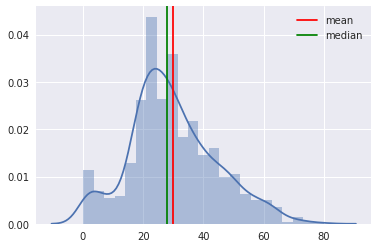

In [13]:
sns.distplot(query_results)
plt.axvline(np.mean(query_results), color='r', label = 'mean')
plt.axvline(np.median(query_results), color='g', label = 'median')
plt.legend()

### Create and interpret a hypothesis test around the average age of male vs female survivors.

1. Write two sql queries
   1. get all male ages that are not `NULL`.
   1. get all female ages that are not `NULL`. 
1. State your null and alternate hypothesis.
2. Use `scipy.stats.ttest_ind` to run a t-test using the two vectors, state your t-statistic and p-value.
3. Interpret your p-value. 

Null hypothesis: There is no difference in the distributions of ages for men and women aboard the titanic.

Alternate hypothesis: The distributions of ages for men and women aboard the titanic are different.

In [14]:
# get all male ages that are not NULL.

connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT age
              FROM titanic
              WHERE sex = 'male' AND age IS NOT NULL ;
              """)
query_results_male = cursor.fetchall()

connection.close()

In [15]:
# get all female ages that are not NULL.

connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT age
              FROM titanic
              WHERE sex = 'female' AND age IS NOT NULL;
              """)
query_results_female = cursor.fetchall()

connection.close()

In [16]:
sp.stats.ttest_ind(query_results_male, query_results_female)

Ttest_indResult(statistic=array([ 2.06063174]), pvalue=array([ 0.03958549]))

In [17]:
# Interpret your p-value.

# p-value is less than 0.05. We reject the null hypothesis and accept the alternative hypothesis
# that the distributions of ages for men and women aboard the titanic are different.

## 4. clean the data from the `titanic` table

### Get all of the data from the `titanic` table.

1. query all data from the table
2. use `sql_to_df` to write the data to a `DataFrame`

In [18]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT *
              FROM titanic
              """)
query_results = cursor.fetchall()

connection.close()

In [19]:
titanic_df = sql_to_df(query_results)

### Get the column names and add them to the `titanic_df` DataFrame

In [20]:
connection, cursor = connect_and_cursor('michaelgfrantz.com', 'postgres', 'dsism4')
execute_query(connection, cursor, 
              """
              SELECT column_name
              FROM information_schema.columns
              WHERE table_name = 'titanic';
              """)
cols_list = [elem[0] for elem in cursor.fetchall()]
connection.close()

cols_list

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home_dest']

### Apply the column names to the `titanic_df` DataFrame

In [21]:
titanic_df.columns = cols_list
titanic_df.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


### Display number of null rows per column

In [22]:
titanic_df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home_dest     564
dtype: int64

### fill age NA values with median of age

In [23]:
titanic_df['age'] = titanic_df['age'].fillna(titanic_df['age'].median())

### impute fare with mean

In [24]:
titanic_df['fare'] = titanic_df['fare'].fillna(titanic_df['fare'].mean())

### Group the `titanic_df` DataFrame by the `embarked` column

In [25]:
embrk_grp = titanic_df.groupby('embarked')

In [26]:
embrk_grp.count()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,boat,body,home_dest
embarked,,,,,,,,,,,,,
C,270,270,270,270,270,270,270,270,270,118,149,25,172
Q,123,123,123,123,123,123,123,123,123,5,38,7,37
S,914,914,914,914,914,914,914,914,914,170,297,89,535


### fill embarked with the mode using `np.where`

In [27]:
titanic_df['embarked'] = ((titanic_df['embarked'].
                           where(pd.notnull(titanic_df['embarked']), 
                                 titanic_df['embarked'].mode()[0])))

### Display number of null rows per column

In [28]:
titanic_df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            0
cabin        1014
embarked        0
boat          823
body         1188
home_dest     564
dtype: int64

### Drop all columns that contain null values

In [29]:
titanic_df = titanic_df.dropna(axis = 1)

### Verify that there are no remaining null values

In [30]:
titanic_df.isnull().sum()

pclass      0
survived    0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

### Drop the `ticket` column

In [31]:
titanic_df = titanic_df.drop('ticket', axis = 1)

### Make the `name` column the index of the DataFrame

In [32]:
titanic_df = titanic_df.set_index('name')

### Display the cleaned DataFrame

In [33]:
titanic_df.head(3)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
name,,,,,,,,
"Allen, Miss. Elisabeth Walton",1,1,female,29.0000,0,0,211.3375,S
"Allison, Master. Hudson Trevor",1,1,male,0.9167,1,2,151.5500,S
"Allison, Miss. Helen Loraine",1,0,female,2.0000,1,2,151.5500,S


In [34]:
titanic_df.shape

(1309, 8)

In [35]:
titanic_df = titanic_df.drop_duplicates()
titanic_df.shape

(1107, 8)

## 5. Use masking to predict survival


In [36]:
titanic_df[(titanic_df['sex'] == 'female') | (titanic_df['age'] < 10)]['survived'].mean()

0.71881606765327699

In [37]:
female = titanic_df['sex'] == 'female'
children = titanic_df['age'] < 10

In [38]:
model1 = female | children

model2 = female & children

In [39]:
# T = survived, F = did not survive

## Use Seaborn to look at sex vs age colored by survival

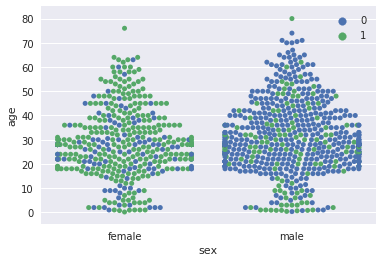

In [40]:
sns.swarmplot(x="sex", y="age", hue="survived", data=titanic_df)
plt.legend()

### Assign the `survived` column to `titanic_target`

In [41]:
titanic_target = titanic_df['survived']

### Drop the `survived` column and assign the result to `titanic_feature`

In [42]:
titanic_feature = titanic_df.drop('survived', axis=1)

### What is the mean of the `titanic_target` vector?

In [43]:
titanic_target.mean()

0.42005420054200543

### What does this value represent?

average survival rate (mean of survived column)

### Define an Accuracy Function

Run this code block to define an accuracy function.

In [44]:
def accuracy_score(actual, predicted):
    
    """ 
    A function that compares a set of actual outcomes to predicted outcomes 
    and returns a proportion from 0 to 1 
    """
    
    return np.array(actual == predicted).mean()

### What does this function do?

compares our predicted survival rate to the actual, and returns the mean of an array of True (1) and False (0) values where True means that our prediction for survival is the same as the actual survival, and False means they are different, so a mean of 1 means we achieved 100% accuracy and a mean of 0 means we achieved 0% accuracy

### Display the first five elements of `titanic_target`

In [45]:
titanic_target.head()

name
Allen, Miss. Elisabeth Walton                      1
Allison, Master. Hudson Trevor                     1
Allison, Miss. Helen Loraine                       0
Allison, Mr. Hudson Joshua Creighton               0
Allison, Mrs. Hudson J C (Bessie Waldo Daniels)    0
Name: survived, dtype: int64

### Predict that all of these people survived

Run this block of code to generate a vector of 5 ones i.e. the first five people survived.

In [46]:
predictions = np.ones(5)

### Run the `accuracy_score` of these `predictions` against the first five elements of `titanic_target`

Run this block of code to test the accuracy of the prediction.

In [47]:
accuracy_score(predictions, titanic_target[:5])

0.40000000000000002

### What does this accuracy score tell us?

That our prediction that all the first five people survived is only 40% accurate, i.e. we can infer that only 40% of them actually survived

### What is the survival rate of the titanic passengers?

38% (from titanic_target.mean())

### Generate a model - no one survived

We can do this by generating a vector of zeros.

In [49]:
n = titanic_feature.shape[0]
model_0_no_survivors = np.zeros(n)

### Calculate the accuracy of this model

In [50]:
print(accuracy_score(titanic_target, model_0_no_survivors))

0.579945799458


### Generate a model using masking - women survived

In [51]:
women = titanic_feature['sex'] == 'female'
model_1_women_survive = women

### Calculate the accuracy of this model

In [52]:
print(accuracy_score(titanic_target, model_1_women_survive))

0.760614272809


### Generate a model using masking - women and children survived

In [53]:
children = titanic_feature['age'] < 10

model_2_women_and_children = women & children

### Calculate the accuracy of this model

In [54]:
print(accuracy_score(titanic_target, model_2_women_and_children))

0.588979223126


### Can you generate a better model using masking?

In [55]:
my_model = women | children # women OR children

In [56]:
print(accuracy_score(titanic_target, my_model))

0.766937669377


In [57]:
first_class = titanic_feature['pclass'] == 1
my_model_2_wom_child_class = women | children & first_class

In [58]:
print(accuracy_score(titanic_target, my_model_2_wom_child_class))

0.76332429991


## 6. Transform the Columns by Label Encoding and One Hot Encoding 

1. Create a new `LabelEncoder`. 
1. Use it to label encode the `sex` column.
1. Save the label encoded vector back to the `titanic_df`.

In [59]:
le = LabelEncoder()
le.fit(titanic_df['sex'])
sex_transformed = le.transform(titanic_df['sex'])

In [60]:
titanic_df['sex'] = sex_transformed

1. Create a new `LabelEncoder`. 
1. Use it to label encode the `embarked` column.
1. Save the label encoded vector back to the `titanic_df`.

In [61]:
le2 = LabelEncoder()
le2.fit(titanic_df['embarked'])
embarked_transformed = le2.transform(titanic_df['embarked'])

In [62]:
le2.classes_ 

array(['C', 'Q', 'S'], dtype=object)

In [63]:
titanic_df['embarked'] = embarked_transformed

1. Create a new `OneHotEncoder`. 
1. Use it to one hot encode the `embarked` column.
1. Save the one hot encoded dataframe as `embarked_df`.
1. Name the columns of `embarked_df` appropriately.
1. Assign `titanic_df.index` to the `embarked_df`.


In [64]:
one_hot = OneHotEncoder(sparse=False)
embarked = titanic_df['embarked'].reshape(-1,1)
one_hot.fit(embarked)
one_hot_embarked = one_hot.transform(embarked)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [65]:
embarked_df = (pd.DataFrame(one_hot_embarked, 
                            columns=['embarked_'+str(c) for c in le2.classes_], 
                            index = titanic_df.index))
embarked_df.head(2)

,embarked_C,embarked_Q,embarked_S
name,,,
"Allen, Miss. Elisabeth Walton",0.0,0.0,1.0
"Allison, Master. Hudson Trevor",0.0,0.0,1.0


### Create a new dataframe called `titanic_numerical_df` by merging `titanic_df` and `embarked_df`.

1. Use `pd.merge` with the following pattern (used when the two DataFrames have indentical `index` columns).

    pd.merge(df_1, df_1, left_index=True, right_index=True)
1. Drop the label encoded `embarked` column from `titanic_numerical_df`

In [66]:
titanic_numerical_df = pd.merge(titanic_df, embarked_df, left_index=True, right_index=True)
titanic_numerical_df = titanic_numerical_df.drop('embarked', axis=1)

### Assign the `survived` column to the vector `y` and drop it from `titanic_numerical_df`

In [67]:
y = titanic_numerical_df['survived']
titanic_numerical_df = titanic_numerical_df.drop('survived', axis=1)


### Display the `head` of your numerical dataframe

In [68]:
titanic_numerical_df.head()

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
name,,,,,,,,,
"Abbing, Mr. Anthony",3,1,42.0,0,0,7.55,0.0,0.0,1.0
"Abbott, Master. Eugene Joseph",3,1,13.0,0,2,20.25,0.0,0.0,1.0
"Abbott, Mr. Rossmore Edward",3,1,16.0,1,1,20.25,0.0,0.0,1.0
"Abbott, Mrs. Stanton (Rosa Hunt)",3,0,35.0,1,1,20.25,0.0,0.0,1.0
"Abelseth, Miss. Karen Marie",3,0,16.0,0,0,7.65,0.0,0.0,1.0


In [69]:
titanic_numerical_df.describe()

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
count,1111.0000,1111.0000,1111.0000,1111.0000,1111.0000,1111.0000,1111.0000,1111.000,1111.0000
mean,2.2214,0.6112,29.8483,0.5167,0.4338,36.6606,0.2205,0.081,0.6985
std,0.8572,0.4877,13.8117,0.9555,0.9128,55.1013,0.4148,0.273,0.4591
min,1.0000,0.0000,0.1667,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
25%,1.0000,0.0000,22.0000,0.0000,0.0000,8.0500,0.0000,0.000,0.0000
50%,3.0000,1.0000,28.0000,0.0000,0.0000,16.0000,0.0000,0.000,1.0000
75%,3.0000,1.0000,37.0000,1.0000,1.0000,35.5000,0.0000,0.000,1.0000
max,3.0000,1.0000,80.0000,8.0000,9.0000,512.3292,1.0000,1.000,1.0000


# 7. (Optional) Clustering via a covariance matrix

### Scale Transform the `titanic_numerical_df`

In [70]:
titanic_scaled = (titanic_numerical_df - titanic_numerical_df.mean())/titanic_numerical_df.std()
titanic_scaled.head(2)

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
name,,,,,,,,,
"Abbing, Mr. Anthony",0.9083,0.7973,0.8798,-0.5407,-0.4753,-0.5283,-0.5317,-0.2968,0.6567
"Abbott, Master. Eugene Joseph",0.9083,0.7973,-1.2199,-0.5407,1.7157,-0.2978,-0.5317,-0.2968,0.6567


### Attach a column of `ones` to the scaled `titanic_numerical_df`

In [71]:
o = np.ones(len(titanic_scaled['age']))

In [72]:
titanic_scaled['ones'] = o

In [73]:
titanic_scaled.head()

,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,ones
name,,,,,,,,,,
"Abbing, Mr. Anthony",0.9083,0.7973,0.8798,-0.5407,-0.4753,-0.5283,-0.5317,-0.2968,0.6567,1.0
"Abbott, Master. Eugene Joseph",0.9083,0.7973,-1.2199,-0.5407,1.7157,-0.2978,-0.5317,-0.2968,0.6567,1.0
"Abbott, Mr. Rossmore Edward",0.9083,0.7973,-1.0026,0.5059,0.6202,-0.2978,-0.5317,-0.2968,0.6567,1.0
"Abbott, Mrs. Stanton (Rosa Hunt)",0.9083,-1.2531,0.3730,0.5059,0.6202,-0.2978,-0.5317,-0.2968,0.6567,1.0
"Abelseth, Miss. Karen Marie",0.9083,-1.2531,-1.0026,-0.5407,-0.4753,-0.5265,-0.5317,-0.2968,0.6567,1.0


### Build the Covariance Matrix

$$ \text{cov} = A^TA$$

In [74]:
cov = titanic_scaled.T.dot(titanic_scaled)


### Cluster using the Covariance Matrix

1. Generate a $\beta$ (weights) vector

   \begin{align}
   A\vec{\beta} &= \vec{y}\\
   A^TA\vec{\beta} &= A^T\vec{y}\\
   \vec{\beta} &= (A^TA)^{-1}A^T\vec{y}\\
   \end{align}
   
   Remember: 
   
      - you use `.T` to take the transpose
      - you use `np.linalg.inv` to take the inverse
      - you use `np.dot()` to multiply
   
1. Generate a vector of predictions

   $$\hat{y} = A\vec{\beta}$$
   
1. Plot a scatter plot of your predictions
   - use `plt.scatter`
   - use `range(len(predictions))` for your x-axis
   - color the scatter plot using `y` e.g. `c=y`

In [75]:
beta = np.linalg.inv(cov).dot(titanic_scaled.T).dot(y)

In [76]:
predictions = titanic_scaled.dot(beta)

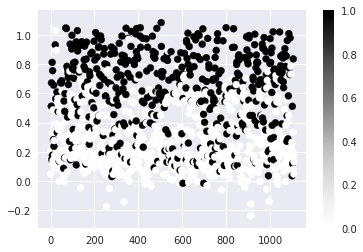

In [77]:
plt.scatter(range(len(predictions)), predictions, c=y)
plt.colorbar()


### Discuss the cluster plot

Color of dots indicates actual survival: black dots indicate they survived, white dots died

y axis is our predictions for survival of each passenger, where 1.0 indicates prediction that they survived and 0.0 prediction that they died